# Titanic's Survivor Prediction

- Objective : Predict the survival of the passengers aboard RMS Titanic.
- Source    : https://www.kaggle.com/c/titanic/data

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

## Overview

The objective, in this case, is to create a model prediction of the survival of the passengers from RMS Titanic. The dataset is downloaded from Kaggel. There are three datasets, training file, testing file, and gender submission file. The training data file will be used to train our model prediction. The testing file will be used to test our model prediction. The gender submission file is a prediction file given by Kaggle. I use this submission file to check our accurate model. Let's get started.

The traing datasets have 891 rows data and 12 columns. The 12 columns are

- PassengerId : the unique id of passenger
- Survived : the survival information of passenger (0 = No, 1 = Yes)
- Pclass : the passenger's class on RMS Titanic
- Name : the passenger's name
- Sex : the passenger's sex (male or female)
- Age : the passenger's age
- SibSp : the number of siblings or spouses aboard the Titanic
- Parch : the number of parrents or childrens aboard the Titanic
- Ticket : the passenger's ticket number
- Fare : the passenger's fare
- Cabin : the passenger's cabin number
- Embarked : the port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [153]:
df_train = pd.read_csv('titanic_train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [128]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Based on the info of training dataset, there are 5 integer data types, 2 float data types, and 5 object data types. From this point, the PassengerId, Name, Ticket, and Cabin features will be removed for further analysis, because these features are not much contribute to predict a survivor. Next, the exploratory data analysis is applied to check whether the datasets have an anomaly or not.

### Exploratory Data Analysis

#### Check Missing Values

[Text(0.5, 0, 'Features'), Text(0, 0.5, 'Number of Missing Value')]

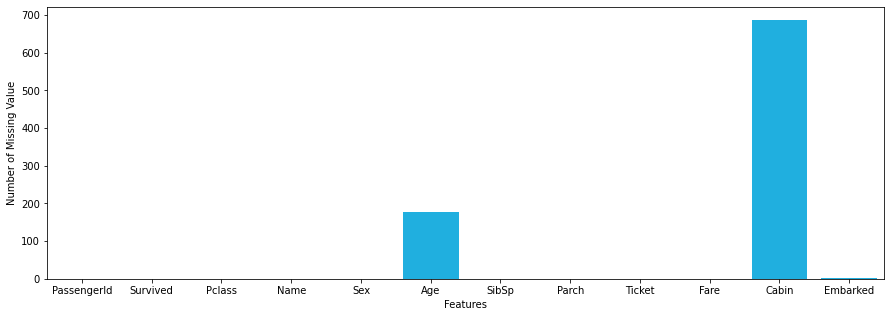

In [129]:
df_missing = df_train.isna().sum().reset_index()
df_missing.columns = ['Feature', 'Missing Value']
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=df_missing, x='Feature', y='Missing Value', color='deepskyblue').set(xlabel='Features', ylabel='Number of Missing Value')

The Cabin feature has highest missing value and Age and Embarked feature are following respectively. The missing value in Cabin feature is hard to be replaced by any values because these values are too specific for each passenger. This feature will be removed from the datasets along with PassengerId, Name, and Ticket featurs. The missing values in Age feature can be replaced by its average. The missing value in Embarked feature can be replaced by its mode.

In [130]:
# Remove the uncessery feature
df_train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

Average of Age: 29.699118 years old


[Text(0.5, 1.0, 'Embarkation Distribution')]

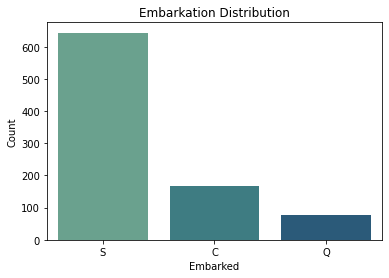

In [48]:
# Calculate the average of age and check the mode of embarkation
average_Age = df_train['Age'].mean()
print('Average of Age: %f years old' % average_Age)
df_embarked = df_train['Embarked'].value_counts().reset_index()
df_embarked.columns = ['Embarked', 'Count']
sns.barplot(data=df_embarked, x='Embarked', y='Count', palette='crest').set(title='Embarkation Distribution')

The average of passenger's age is around 29.69 years old and the S or Southampton is the highest port embarkation. These values are used to replace the missing values.

In [131]:
df_train['Age'].fillna(average_Age, inplace=True)
df_train['Embarked'].fillna('S', inplace=True)

#### How many passengers survived in general?

There are 549 passengers are not survived and 342 passengers survived in RMS Titanic

   Survived  Count
0         0    549
1         1    342


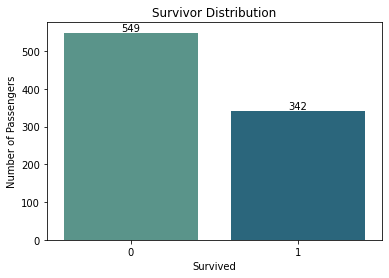

In [132]:
df_survived = df_train['Survived'].value_counts().reset_index()
df_survived.columns = ['Survived', 'Count']
print(df_survived.head())
ax = sns.countplot(data=df_train, x='Survived', palette='crest')
ax.set_ylabel('Number of Passengers')
ax.set_title('Survivor Distribution')
# create annotations
for value in ax.containers:
    ax.bar_label(value)

#### How many passengers survived based Sex?

The female passengers have 68.12% more survivors than the male passengers and there are 468 male passengers who are not survived.

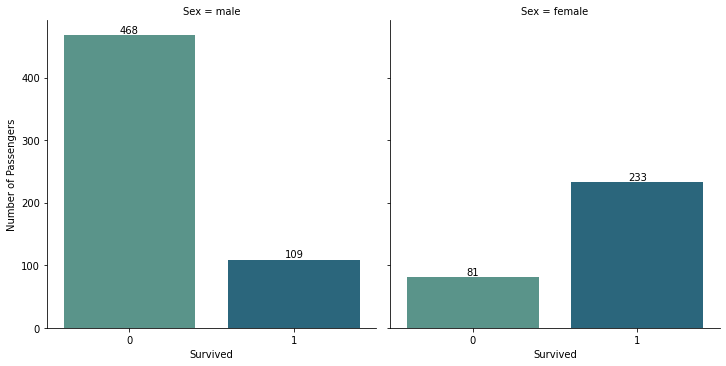

In [133]:
ax = sns.catplot(data=df_train, x='Survived', col='Sex', kind='count', palette='crest')
ax.set_ylabels('Number of Passengers')
# create annotations
for axes in ax.axes.ravel():
    for value in axes.containers:
        axes.bar_label(value)

#### How many passengers survived based on Class?

The first class has more survivors than the other two classes. Then, the third class has more victims than the other two classes.

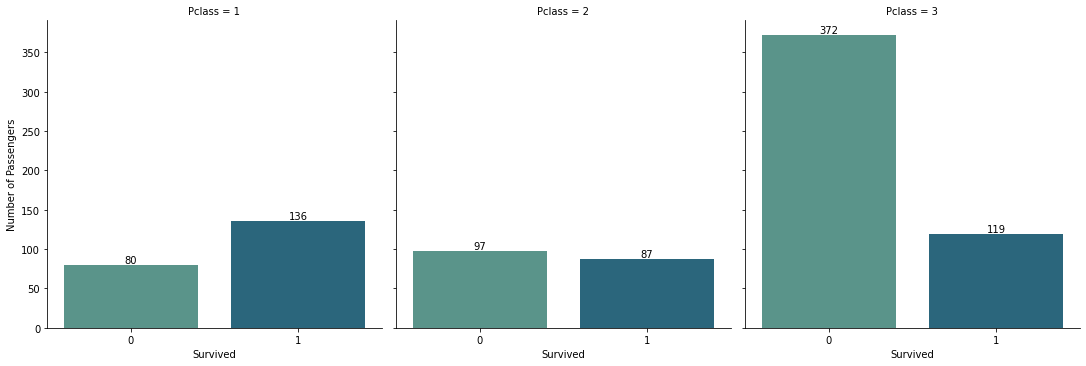

In [134]:
ax = sns.catplot(data=df_train, x='Survived', col='Pclass', kind='count', palette='crest')
ax.set_ylabels('Number of Passengers')
# create annotations
for axes in ax.axes.ravel():
    for value in axes.containers:
        axes.bar_label(value)

#### How many passengers survived based on Siblings or Spouses?

The value of 0 in SibSp indicates that the passenger was a solo traveler. There are 398 victims and only 210 survivors that come from the passenger who was traveling alone, this is the highest number of victims and survivors. However, passengers who are traveling with one of their siblings or spouses have more survived than are not. The passengers who are traveling with more than 2 siblings or spouses have not survived.

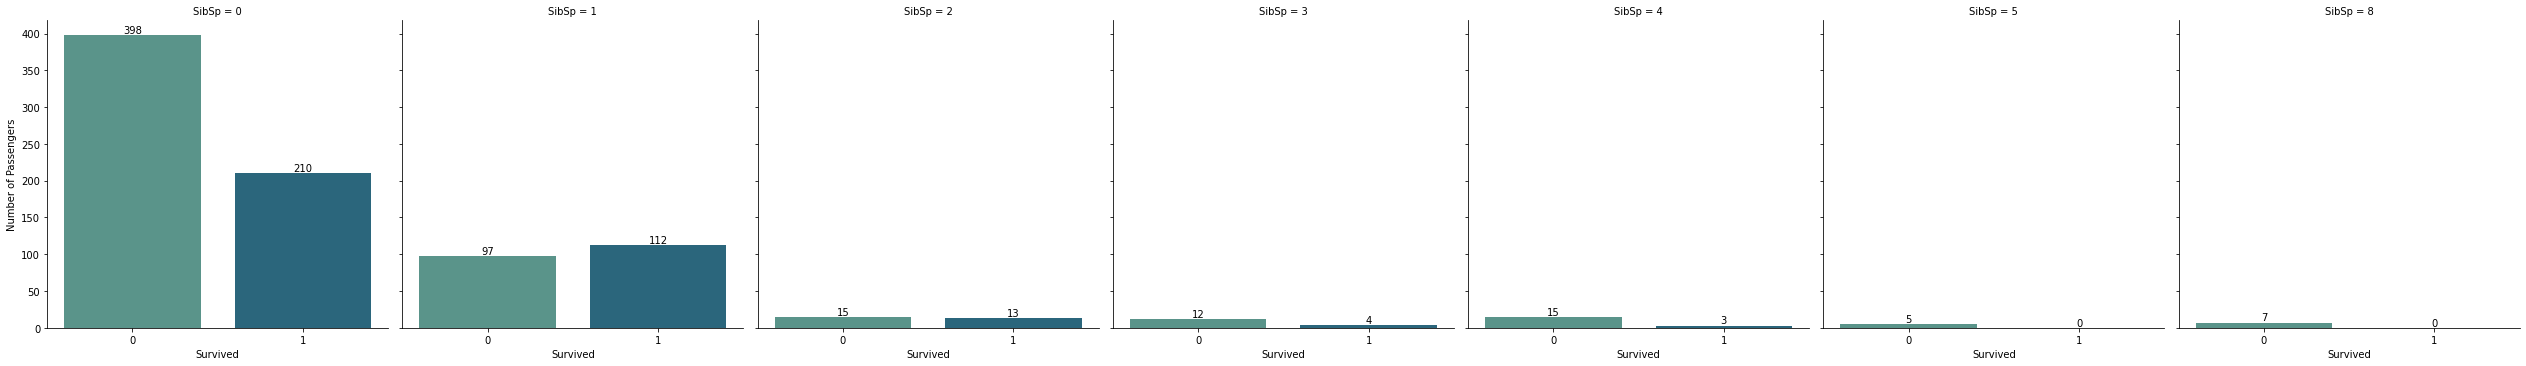

In [135]:
ax = sns.catplot(data=df_train, x='Survived', col='SibSp', kind='count', palette='crest')
ax.set_ylabels('Number of Passengers')
# create annotations
for axes in ax.axes.ravel():
    for value in axes.containers:
        axes.bar_label(value)

#### How many passengers survived based on Parents or Children?

The value of 0 in Parch indicates that the passenger was a solo traveler. There are 445 victims and only 233 survivors that come from the passenger who was traveling alone, this is the highest number of victims and survivors. However, passengers who are traveling with one of their parents or children have more survived than are not. The passengers who are traveling with more than 4 siblings or spouses have not survived.

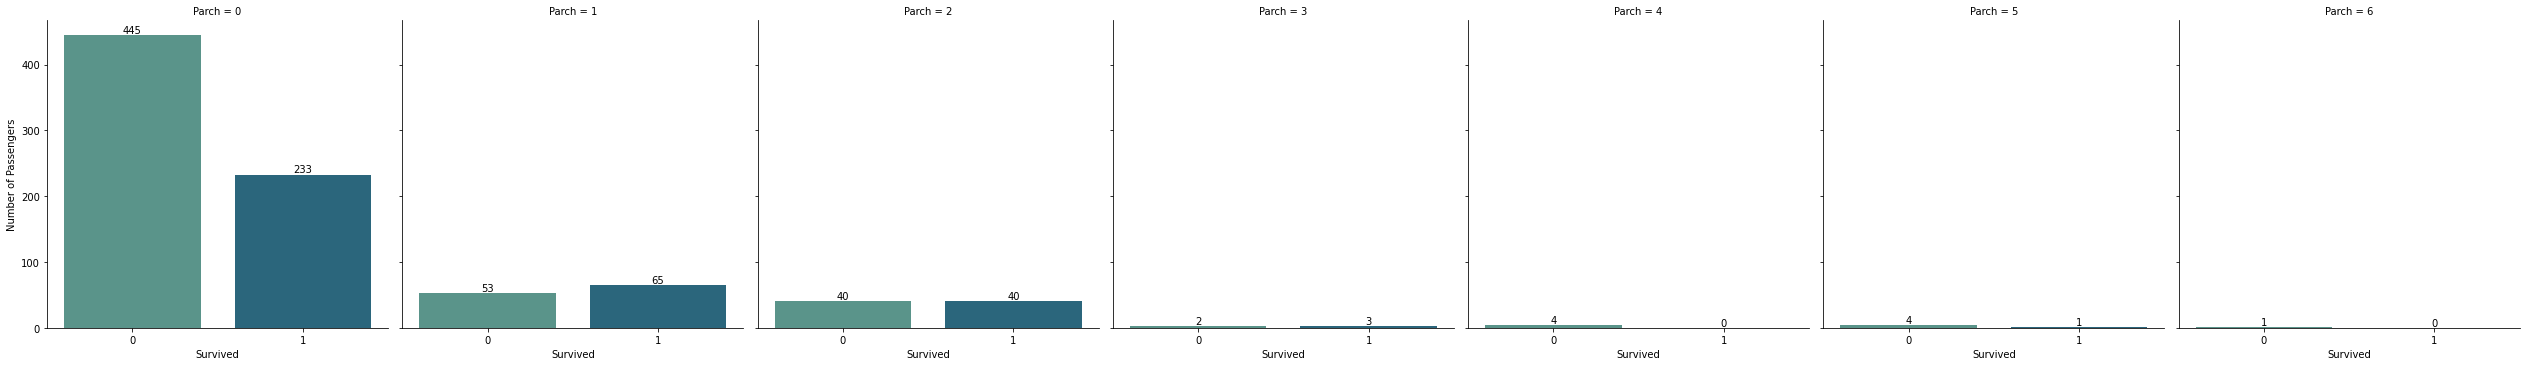

In [136]:
ax = sns.catplot(data=df_train, x='Survived', col='Parch', kind='count', palette='crest')
ax.set_ylabels('Number of Passengers')
# create annotations
for axes in ax.axes.ravel():
    for value in axes.containers:
        axes.bar_label(value)

### What is the correlation between the survivor and fare?

The passengers who survived purchased the high-fare ticket on average.

Text(0.5, 1.0, 'Fare Distribution')

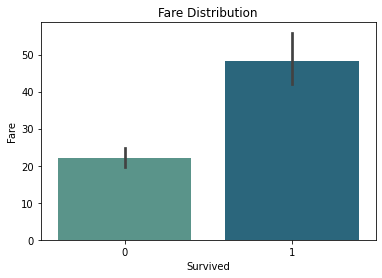

In [137]:
ax = sns.barplot(data=df_train, x='Survived', y='Fare', palette='crest')
ax.set_ylabel('Fare')
ax.set_title('Fare Distribution')


#### What is the distribution of survivors based on their age?

The passengers whether they survived or not, have the same age range of 20-40 years old. Passengers below 10 years old are more survived.

Text(0.5, 1.0, 'Age Distribution')

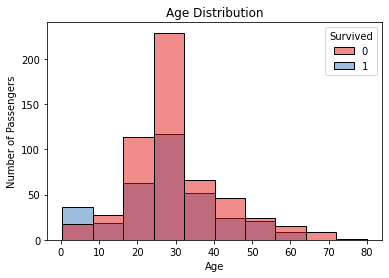

In [138]:
ax = sns.histplot(data=df_train, x='Age', hue='Survived', palette='Set1', bins=10)
ax.set_ylabel('Number of Passengers')
ax.set_title('Age Distribution')

In [139]:
df_train.columns.tolist()

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

According to this exploratory data analysis. I will take several features to be used for creating a survival prediction model, these features are Age, Pclass, SibSp, Parch, Fare,Sex, Embarked, and Survived. The Survive feature will be used as target model. The value of Sex feature will be replaced by binary values (male=1, female=0). The values in Embarked will be converted to numeric values.

In [140]:
encoder = LabelEncoder()
df_train['Sex'] = encoder.fit_transform(df_train['Sex'])
df_train['Embarked'] = encoder.fit_transform(df_train['Embarked'])
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


### Creating a Model Prediction

Now, I am going to split the dataset into 80% training data set and 20% testing dataset.

In [142]:
model = df_train.drop('Survived', axis=1)
target = df_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(model, target, test_size=0.2, random_state=42)
print('X train %d rows and %d columns' % X_train.shape)
print('X test %d rows and %d columns' % X_test.shape)
print('y train %d rows' % y_train.shape)
print('y test %d rows' % y_test.shape)

X train 712 rows and 7 columns
X test 179 rows and 7 columns
y train 712 rows
y test 179 rows


Because the objective is to predict the survivor (survived or not survived), I use the classification algorithm called Logistic Regression to create a survival prediction model.

[Text(33.0, 0.5, 'Actual'),
 Text(0.5, 15.0, 'Predicted'),
 Text(0.5, 1.0, 'Confusion matrix')]

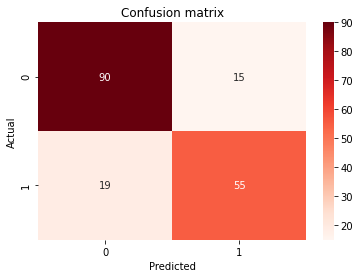

In [149]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Reds').set(ylabel='Actual', xlabel='Predicted', title='Confusion matrix')

In [150]:
print('Accuracy: %f %s' % (accuracy_score(y_test, y_pred)*100, '%'))
print('Mised Classficiation Rate: %f %s' % (100 - (accuracy_score(y_test, y_pred)*100), '%'))
print('Precision: %f %s' % (precision_score(y_test, y_pred)*100, '%'))
print('Recall (Positive Rate): %f %s' % (recall_score(y_test, y_pred)*100, '%'))

Accuracy: 81.005587 %
Mised Classficiation Rate: 18.994413 %
Precision: 78.571429 %
Recall (Positive Rate): 74.324324 %


According to model that has been created, the model
- predict 90 passengers are not survived that actually they are not survived
- predict 15 passengers are survived but actually they are not survived
- predict 19 passengers are not survived but actually they are survived
- predict 55 passengers are survived that actually thet are survived

This model gives 81 % of accuracy. It means this model is good enough to predict the passengers either survived or not. For the specific analysis, this model gives 78.57 % of the recall parameter. The Recall parameter describes the quality of the correct prediction from the entire data that have been really correctly predicted. This model is quite good enough to predict passengers who really survived.

Next, let's try the model to the given testing file.

### Testing a Model

The testing model file have 418 rows and 11 columns. The target feature (Survived) is in gender submission file.

In [161]:
df_test = pd.read_csv('titanic_test.csv')
df_test.shape

(418, 11)

In [162]:
df_survived_prepred = pd.read_csv('titanic_gender_submission.csv')
df_survived_prepred.shape

(418, 2)

In [163]:
y_survived_prepred = df_survived_prepred['Survived']

In [164]:
df_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [165]:
# Encode the Sex and Embarked features
df_test['Sex'] = encoder.fit_transform(df_test['Sex'])
df_test['Embarked'] = encoder.fit_transform(df_test['Embarked'])

av_age = df_test['Age'].mean()
av_fare = df_test['Fare'].mean()
df_test['Age'].fillna(av_age, inplace=True)
df_test['Fare'].fillna(av_fare, inplace=True)
y_survived_modelpred = logreg.predict(df_test)

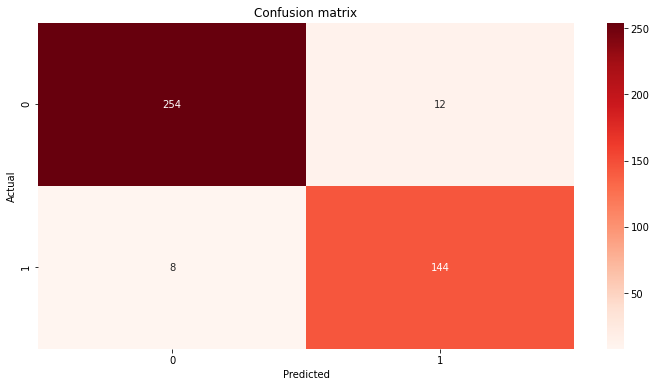

In [271]:
cm = confusion_matrix(y_survived_prepred, y_survived_modelpred)
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Reds', fmt='d').set(ylabel='Actual', xlabel='Predicted', title='Confusion matrix')
plt.savefig('titanic_cm_8.jpeg')

In [173]:
print('Accuracy: %f %s' % (accuracy_score(y_survived_prepred, y_survived_modelpred)*100, '%'))
print('Mised Classficiation Rate: %f %s' % (100 - (accuracy_score(y_survived_prepred, y_survived_modelpred)*100), '%'))
print('Precision: %f %s' % (precision_score(y_survived_prepred, y_survived_modelpred)*100, '%'))
print('Recall (Positive Rate): %f %s' % (recall_score(y_survived_prepred, y_survived_modelpred)*100, '%'))

Accuracy: 95.215311 %
Mised Classficiation Rate: 4.784689 %
Precision: 92.307692 %
Recall (Positive Rate): 94.736842 %


In [227]:
df_test['Survived-PrePred'] = y_survived_prepred
df_test['Survived-ModPred'] = y_survived_modelpred
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived-PrePred,Survived-ModPred
0,3,1,34.5,0,0,7.8292,1,0,0
1,3,0,47.0,1,0,7.0000,2,1,0
2,2,1,62.0,0,0,9.6875,1,0,0
3,3,1,27.0,0,0,8.6625,2,0,0
4,3,0,22.0,1,1,12.2875,2,1,1


[  0. 152.]
[266.   0.]


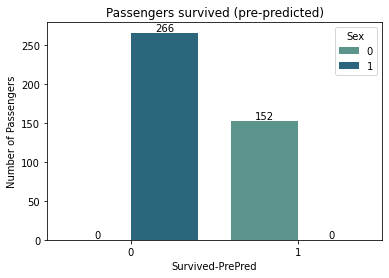

In [263]:
ax = sns.countplot(data=df_test, x='Survived-PrePred', hue='Sex', palette='crest')
ax.set_ylabel('Number of Passengers')
ax.set_title('Passengers survived (pre-predicted)')

# Create annotation
for label in ax.containers:
    label.datavalues.setflags(write=1)
    label.datavalues[np.isnan(label.datavalues)] = 0
    ax.bar_label(label)
plt.show()

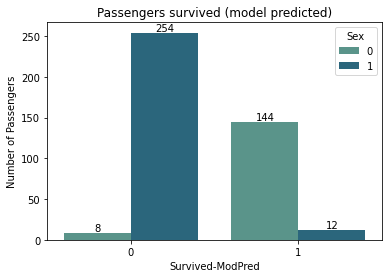

In [265]:
ax = sns.countplot(data=df_test, x='Survived-ModPred', hue='Sex', palette='crest')
ax.set_ylabel('Number of Passengers')
ax.set_title('Passengers survived (model predicted)')

# Create annotation
for label in ax.containers:
    ax.bar_label(label)
plt.show()

By comparing with the given testing file and submission file (pre-predicted), this model gives 95.21 % of accuracy and 94.73 % of recall. In the pre-predicted file, only female passengers survived (152 passengers) while the model predicts 133 female passengers survived and 8 female passengers have not survived.

### Conclusions

Overall, the female passengers more survive than male passengers. There are some passengers survived who have age below 10 years old. The survivors had purchased the high-fare ticket. The model for survivor prediction has been created by using Logistic Regression. This model is good enough to predict survivor by 94.73 %.